Challenge 5: KMeans and DBSCAN Clustering Algorithms

In [1]:
#Import Required Libraries
import time
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# cd drive/My\ Drive/Colab\ Notebooks/

In [4]:
aws = pd.read_csv(r'aws_honeypot_geo.csv')
aws.head()

,host,src,proto,spt,dpt,srcstr,country,locale,postalcode,latitude,longitude
0,groucho-oregon,1032051418,TCP,6000.0,1433.0,61.131.218.218,China,Jiangxi Sheng,NaN,28.5500,115.9333
1,groucho-oregon,1347834426,UDP,5270.0,5060.0,80.86.82.58,Germany,NaN,NaN,51.0000,9.0000
2,groucho-oregon,2947856490,TCP,2489.0,1080.0,175.180.184.106,Taiwan,Taipei,NaN,25.0392,121.5250
3,groucho-us-east,841842716,UDP,43235.0,1900.0,50.45.128.28,United States,Oregon,97124,45.5848,-122.9117
4,groucho-singapore,3587648279,TCP,56577.0,80.0,213.215.43.23,France,NaN,NaN,48.8600,2.3500


In [5]:
aws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451581 entries, 0 to 451580
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   host        451581 non-null  object 
 1   src         451581 non-null  int64  
 2   proto       451581 non-null  object 
 3   spt         406770 non-null  float64
 4   dpt         406770 non-null  float64
 5   srcstr      451581 non-null  object 
 6   country     447947 non-null  object 
 7   locale      342112 non-null  object 
 8   postalcode  86478 non-null   object 
 9   latitude    448112 non-null  float64
 10  longitude   448153 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 37.9+ MB


As we can see in the above summary, the Postalcode feature has about 80% of its values as NaNs. Hence, we will drop this column from the dataset.

In [6]:
aws = aws.drop(columns=['postalcode'])
aws.head()

,host,src,proto,spt,dpt,srcstr,country,locale,latitude,longitude
0,groucho-oregon,1032051418,TCP,6000.0,1433.0,61.131.218.218,China,Jiangxi Sheng,28.5500,115.9333
1,groucho-oregon,1347834426,UDP,5270.0,5060.0,80.86.82.58,Germany,NaN,51.0000,9.0000
2,groucho-oregon,2947856490,TCP,2489.0,1080.0,175.180.184.106,Taiwan,Taipei,25.0392,121.5250
3,groucho-us-east,841842716,UDP,43235.0,1900.0,50.45.128.28,United States,Oregon,45.5848,-122.9117
4,groucho-singapore,3587648279,TCP,56577.0,80.0,213.215.43.23,France,NaN,48.8600,2.3500


In the dataset, for **Proto = ICMP**, the Source and Destination Port Features do not contain any data. Hence, to improve the performance of the models, remove all the ICMP records. \
And we will only consider records that are not **NaN** in Country and then subsequently, Latitude and Longitude columns.

In [7]:
aws.loc[aws['proto']=='ICMP']

,host,src,proto,spt,dpt,srcstr,country,locale,latitude,longitude
51,groucho-eu,2148114514,ICMP,NaN,NaN,128.9.160.82,United States,California,33.9777,-118.4351
52,groucho-eu,2148114514,ICMP,NaN,NaN,128.9.160.82,United States,California,33.9777,-118.4351
59,groucho-singapore,782615554,ICMP,NaN,NaN,46.165.196.2,Germany,NaN,51.0000,9.0000
148,groucho-oregon,249236627,ICMP,NaN,NaN,14.219.12.147,China,Guangdong,23.1167,113.2500
149,groucho-oregon,249236627,ICMP,NaN,NaN,14.219.12.147,China,Guangdong,23.1167,113.2500
...,...,...,...,...,...,...,...,...,...,...
451531,groucho-singapore,2148116578,ICMP,NaN,NaN,128.9.168.98,United States,California,33.9777,-118.4351
451536,groucho-sa,3093246218,ICMP,NaN,NaN,184.95.49.10,United States,Arizona,33.4357,-111.9171
451562,groucho-sa,3233452889,ICMP,NaN,NaN,192.186.147.89,Canada,Ontario,43.6525,-79.3686
451571,groucho-tokyo,2169670188,ICMP,NaN,NaN,129.82.138.44,United States,Colorado,40.4555,-105.4648


In [8]:
aws.drop(aws.loc[aws['proto'] == 'ICMP' ].index, inplace = True)
aws = aws[aws['country'].notna()]
aws = aws[aws['latitude'].notna()]

In [9]:
columns = aws.columns.tolist()
le = preprocessing.LabelEncoder()
for column in columns:
    aws[column]= aws[column].fillna('0')
    print(' Unique Values in {x} = {length} '.format(x=column,length=len(aws[column].unique())))
    if column!='src':
        aws[column] = le.fit_transform(aws[column])

print('\n', aws.head())

 Unique Values in host = 9 
 Unique Values in src = 64363 
 Unique Values in proto = 2 
 Unique Values in spt = 46025 
 Unique Values in dpt = 4030 
 Unique Values in srcstr = 64363 
 Unique Values in country = 177 
 Unique Values in locale = 1153 
 Unique Values in latitude = 4902 
 Unique Values in longitude = 5065 

    host         src  proto    spt  dpt  srcstr  country  locale  latitude  \
0     2  1032051418      0   4994  542   52433       36     380      1037   
1     2  1347834426      1   4548  994   58024       57       0      4287   
2     2  2947856490      0   1810  189   22424      157     996       880   
3     7   841842716      1  27792  640   49070      169     663      3659   
4     4  3587648279      0  39045   26   37662       54       0      4017   

   longitude  
0       4714  
1       3065  
2       4810  
3         49  
4       2731  


Implementing **KMeans** Clustering algorithm with number of clusters ranging from 2 to 6 and evaluating the model with **Silhouette Analysis**.

In [10]:
range_n_clusters = range(2,7)
silhouette_scores = []
labels_list = []

In [11]:
random_sample = aws.sample(45000)
X = random_sample.iloc[:,:].values

In [12]:
# Initialize the clusterer with n_clusters value:
for n_clusters in range_n_clusters:
    start = time.time()
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(random_sample)
    cluster_labels = clusterer.labels_
    labels_list.append(cluster_labels)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    end = time.time()
    duration = end-start
    print("For n_clusters = {x} the average silhouette_score is : {y} with execution time : {z}".format(x=n_clusters,
                                                                                                        y=silhouette_avg,
                                                                                                        z = duration))

For n_clusters = 2 the average silhouette_score is : 0.6937098307437829 with execution time : 21.360769748687744
For n_clusters = 3 the average silhouette_score is : 0.6863245983187922 with execution time : 20.394779205322266
For n_clusters = 4 the average silhouette_score is : 0.708718986734591 with execution time : 21.497837781906128
For n_clusters = 5 the average silhouette_score is : 0.6805355678060729 with execution time : 20.82302975654602
For n_clusters = 6 the average silhouette_score is : 0.6875778993139312 with execution time : 23.331088304519653


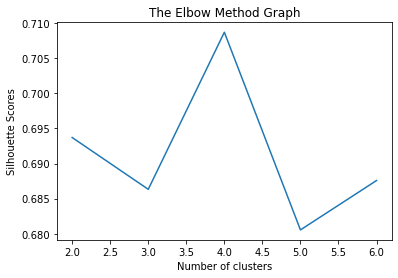


 The maximum silhouette score is observed at k = 4 with score = 0.708718986734591 


In [13]:
# Plot the elbow graph
plt.plot(range_n_clusters,silhouette_scores)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.show()

# Get the max silhouette score and the corresponding value of k clusters:
max_score = max(silhouette_scores)
n_clusters = silhouette_scores.index(max_score) + 2
print('\n The maximum silhouette score is observed at k = {x} with score = {y} '.format(x=n_clusters,y=max_score))

Plotting the Silhouette Analysis and Clusters for k with maximum silhouette score:

In [14]:
# Training the model again:
clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(aws)
cluster_labels = clusterer.labels_
X = aws.iloc[:,:].values

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X, cluster_labels)

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

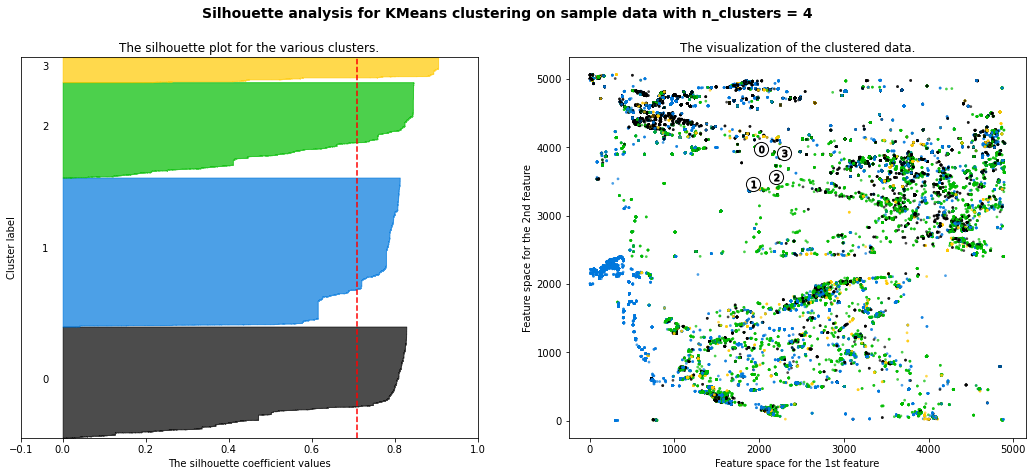

In [15]:
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 8], X[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 8], centers[:, 9], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[8], c[9], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Implementing **DBSCAN** Clustering algorithm with **Eps= 0.4** and **Min Sample = 10**


In [16]:
start = time.time()
clustering = DBSCAN(eps=0.4, min_samples=10).fit(aws)
end = time.time()
duration = end-start
print('Time Elapsed: {x} seconds'.format(x=duration))
labels = clustering.labels_
X = aws.iloc[:,:].values
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Cluster:',n_clusters_,' and Noise:', n_noise_)

Time Elapsed: 28.650213718414307 seconds
Number of Cluster: 3103  and Noise: 284793


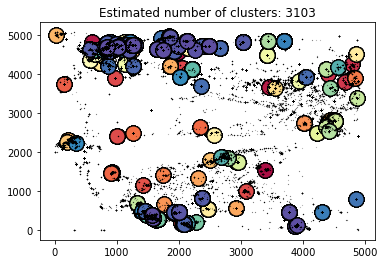

In [17]:
# Plotting the DBSCAN Clusters:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 8], xy[:, 9], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=15)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 8], xy[:, 9], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [24]:
start = time.time()
clustering = DBSCAN(eps=0.4, min_samples=100).fit(aws)
end = time.time()
duration = end-start
print('Time Elapsed: {x} seconds'.format(x=duration))
labels = clustering.labels_
X = aws.iloc[:,:].values
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Cluster:',n_clusters_,' and Noise:', n_noise_)

Time Elapsed: 18.76537561416626 seconds
Number of Cluster: 101  and Noise: 351049


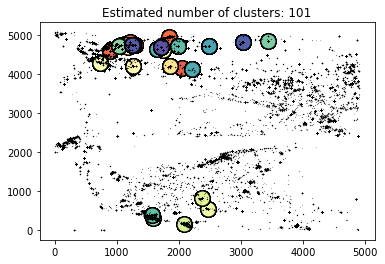

In [25]:
# Plotting the DBSCAN Clusters:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 8], xy[:, 9], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=15)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 8], xy[:, 9], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

From the plots, we can observe how the two clustering algorithms perform and generate clusters in varying depth of detail.